In [1]:
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from utils.utils import eval_dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
data = pd.read_csv("D:\Datasets\epileptic\Epileptic_Seizure_Recognition.csv")
data = data.drop(columns=['Unnamed'])
data.loc[data["y"] > 1 , "y"] = 1   #0 - seizure, >0 - no seizure
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [7]:
#normalized_data=(data-data.mean())/data.std()
normalized_data=(data-data.min())/(data.max()-data.min())
normalized_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,0.553717,0.571107,0.584371,0.598207,0.599275,0.526728,0.486466,0.462484,0.464883,0.467297,...,0.507684,0.554390,0.544073,0.521051,0.489858,0.454331,0.434953,0.435612,0.474893,0.75
1,0.624123,0.625176,0.620328,0.629447,0.637957,0.579905,0.551431,0.535948,0.536146,0.536280,...,0.557355,0.603836,0.603850,0.593542,0.562101,0.528396,0.505486,0.495495,0.522970,0.00
2,0.506872,0.506618,0.506229,0.522997,0.531581,0.481668,0.457592,0.445752,0.451505,0.452989,...,0.527991,0.578064,0.570753,0.551440,0.515143,0.479717,0.456113,0.448331,0.478900,1.00
3,0.486396,0.489158,0.492356,0.507087,0.514355,0.465155,0.445991,0.438693,0.450990,0.456822,...,0.489846,0.534612,0.527524,0.521051,0.494860,0.467417,0.446447,0.439322,0.471154,1.00
4,0.513324,0.499296,0.491789,0.504194,0.517679,0.478310,0.468162,0.464837,0.467970,0.461932,...,0.513447,0.559485,0.550490,0.535296,0.507085,0.470557,0.443574,0.434022,0.469017,1.00


In [136]:
target = 'cardio'

In [137]:
X = data.drop(columns=[target])
#normalize data
#X=(X-X.mean())/X.std()
y = data[target]

In [138]:
model_ctgan = CTGANSynthesizer(epochs=5)
model_ctgan.fit(data)

KeyboardInterrupt: 

In [ ]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]

In [ ]:
normalized_samples=(samples-samples.min())/(samples.max()-samples.min())

## Privacy

In [ ]:
import numpy as np

def get_nearest(src_point, candidates):
    min_dist = 1000
    min_index = 0
    for i in range(len(candidates)):
        dist = np.linalg.norm(src_point - candidates.iloc[[i]])
        print(candidates.iloc[[i]])
        print("{:.2f}".format(dist))
        if dist < min_dist:
            min_dist = dist
            min_index = i

    return min_index, min_dist

In [ ]:
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1):
    '''
    Find nearest neighbors for all source points from a set of candidate points
    '''
    # Create tree from the candidate points
    #knn = NearestNeighbors(n_neighbors=3)
    tree = BallTree(candidates, leaf_size=15)
    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)
    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()
    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]
    # Return indices and distances
    return closest, closest_dist

In [ ]:
def avg_dist(src_points, candidates):
    sum_dist = 0
    for i in range(len(src_points)):
        index, dist = get_nearest(src_points.iloc[[i]], candidates)
        sum_dist += dist
        
    return sum_dist/i 


In [ ]:
normalized_samples = normalized_samples.apply(pd.to_numeric) # convert all columns of DataFrame
normalized_data = normalized_data.apply(pd.to_numeric) # convert all columns of DataFrame

In [ ]:
# example
closest, dist = get_nearest(normalized_samples.iloc[[0]], normalized_data)
print(closest, dist)

[45389] [0.49213666]


In [ ]:
avg_distance = avg_dist(normalized_samples[:1000], normalized_data[:1000])

In [ ]:
print(avg_distance)

[0.53182884]


## Fidelity

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

def get_predictions(X_train, y_train, X_test, y_test):
    learners = [(AdaBoostClassifier(n_estimators=50))]
    #learners = [(RandomForestClassifier())]

    history = dict()

    for i in range(len(learners)):
        model = learners[i]
        model.fit(X_train, y_train)

        #first letter is data where it trained, second is data where it tested
        pred = []

        for j in range (len(X_test)):
            #print(X_test.loc[[j]])
            pred.append(model.predict(X_test.iloc[[j]]))
        
    return pred

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

In [ ]:
rf_pred = get_predictions(X_train, y_train, X_syn_test, y_syn_test)
ff_pred = get_predictions(X_syn_train, y_syn_train, X_syn_test, y_syn_test)

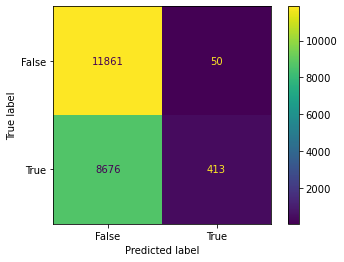

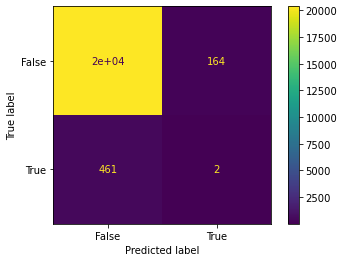

In [ ]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred, rf_pred, ff_pred):
    confusion_matrix1 = metrics.confusion_matrix(rr_pred, fr_pred)
    confusion_matrix2 = metrics.confusion_matrix(fr_pred, ff_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1, display_labels = [False, True])
    cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2, display_labels = [False, True])

    cm_display1.plot()
    cm_display2.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred, rf_pred, ff_pred)

In [139]:
def eval_fidelity(pred1, pred2):
    same_pred = 0
    dif_pred = 0
    if len(pred1) != len(pred2):
        print("Error: different sizes")
    
    for i in range(len(pred1)):
        if pred1[i] == pred2[i]:
            same_pred += 1
        else:
            dif_pred += 1

    return same_pred, dif_pred


In [140]:
same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

In [141]:
print(same_pred, dif_pred)

12274 8726
